In [79]:
import torch
import torchvision
from torch import nn
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset,DataLoader
print(torch.__version__)
print(torchvision.__version__)


2.2.0+cu118
0.17.0+cu118


In [80]:
train_data = datasets.FashionMNIST(root="./data",download=True,train=True,transform=ToTensor(),target_transform=None)
test_data = datasets.FashionMNIST(root="./data",download=True,train=False,transform=ToTensor())
batch_size = 32
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [82]:
class_names = train_data.classes
train_features_batch,train_labels_batch = next(iter(train_loader))
class_names


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [83]:
torch.manual_seed(42)
rand_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[rand_idx],train_labels_batch[rand_idx]

In [84]:
class CNNclf(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=3),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2))
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 20, bias=True),
            nn.ReLU(),
            nn.Linear(20, 10, bias=True))

    def forward(self, x):
        x = self.net(x)
        x = self.clf(x)
        return x

In [85]:
torch.manual_seed(42)
model = torch.load('ModelFiles/model.pt').to(device)
model.net.requires_grad = False 
model

CNNclf(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

In [87]:
def accuracy_fn(y,y_pred):
    correct = torch.eq(y_pred,y).sum().item()
    acc = (correct/len(y_pred))*100
    return acc


In [88]:
def train_step(model,data_loader,device,optimizer,loss_fn,accuracy_fn):
    train_loss,train_acc = 0,0
    model.to(device)
    for batch,(X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} Train accuracy: {train_acc:.5f}")


def test_step(model,data_loader,device,optimizer,loss_fn,accuracy_fn):
    test_loss,test_acc = 0,0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred,y)
            test_acc += accuracy_fn(y,y_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}")

In [89]:
torch.manual_seed(42)
epochs = 3
for epoch in range(epochs):
    print(f"Epoch:{epoch}\n--------")
    train_step(model,train_loader,device,optimizer,loss_fn,accuracy_fn)
    test_step(model,test_loader,device,optimizer,loss_fn,accuracy_fn)

Epoch:0
--------


Train loss: 0.48777 Train accuracy: 82.34833
Test loss: 0.34537 | Test accuracy: 87.81949
Epoch:1
--------
Train loss: 0.30158 Train accuracy: 88.99833
Test loss: 0.30828 | Test accuracy: 88.50839
Epoch:2
--------
Train loss: 0.25380 Train accuracy: 90.77500
Test loss: 0.28357 | Test accuracy: 89.78634


In [90]:
def make_predictions(model,data,device):
    pred_probs = []
    model.eval()
    for sample in data:
        with torch.inference_mode():
            sample = torch.unsqueeze(sample,dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [91]:
import random
random.seed(42)
test_samples,test_labels = [],[]
for sample,label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [92]:
pred_probs = make_predictions(model,test_samples,device)
pred_probs[:2]

tensor([[4.7952e-10, 4.7103e-14, 3.5490e-12, 1.6511e-13, 2.2116e-12, 9.9998e-01,
         1.1491e-08, 6.5423e-09, 9.1733e-06, 6.5456e-06],
        [4.4265e-05, 9.9712e-01, 3.8537e-04, 9.1647e-05, 1.6039e-03, 2.1226e-08,
         7.1512e-04, 2.1496e-05, 1.5698e-05, 3.3709e-06]])

In [93]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [94]:
test_labels,pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

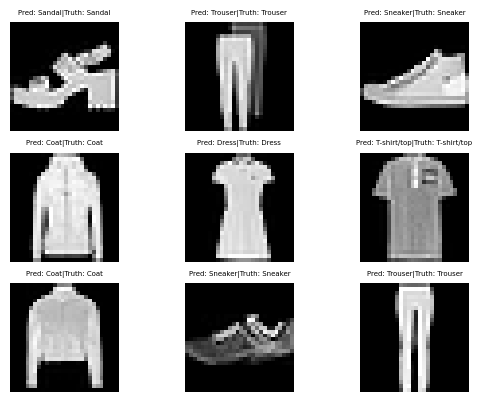

In [95]:
import matplotlib.pyplot as plt 
rows,cols = 3,3
for i,sample in enumerate(test_samples):
    plt.subplot(rows,cols,i+1)
    plt.imshow(sample.squeeze(),cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    plt.title(f"Pred: {pred_label}|Truth: {truth_label}",fontsize=5)
    
    plt.axis(False)

In [96]:
y_preds = []
model.eval()
with torch.inference_mode():
    for X,y in test_loader:
        X,y = X.to(device),y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
y_preds_tensor = torch.cat(y_preds)

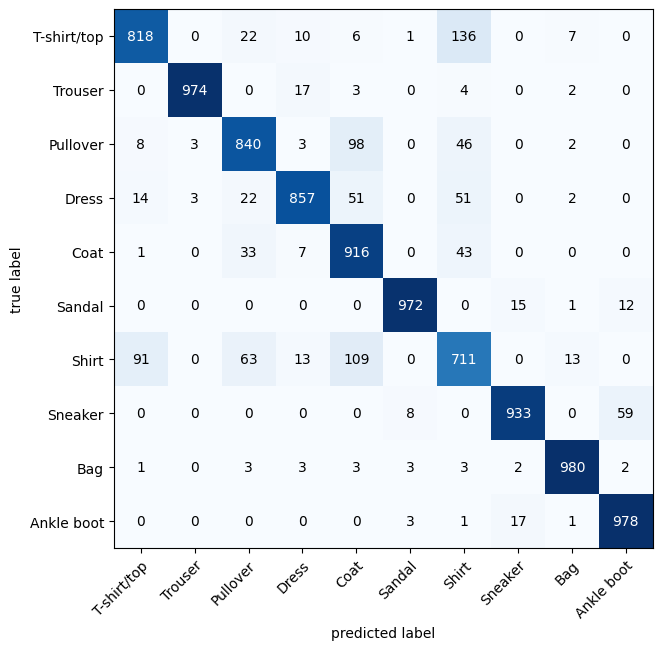

In [101]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_preds_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7))


Learn the AlexNet architecture and apply transfer learning to perform the classification task. Using the pre-trained AlexNet, classify images from the cats_and_dogs_filtered dataset downloaded from the below link. Finetune the classifier given in AlexNet as a twoclass classifier. Perform pre-processing of images as per the requirement.

In [107]:
import torch
import torchvision
from torchvision import datasets, transforms
import os


data_dir = r"C:\Users\rsurs\OneDrive\Documents\University_Study Material\3rd year\6th sem\DL_lab\Lab-6\cats_and_dogs_filtered"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "validation")

# Step 2: Load Pre-trained AlexNet
alexnet = torchvision.models.alexnet(pretrained=True)
print(alexnet)

# Step 3: Modify Classifier for Two-Class Classification
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(num_features, 2)  # Two output classes (cats and dogs)

# Step 4: Preprocess Images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(train_dir, transform=image_transforms)
test_data = datasets.ImageFolder(test_dir, transform=image_transforms)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Step 5: Fine-tune the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

optimizer = torch.optim.SGD(params=alexnet.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

num_epochs = 10
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_data)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation on test data
alexnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test data: {accuracy:.4f}")


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 